# Spotify Data Visualization - Scott Berry

## Load environmental variables for Spotify client

To create a Spotify API client, we need to visit [Spotify Dashboard](https://developer.spotify.com/dashboard/applications) and create an app. Upon app creation, Spotify generates a `client_id` and `client_secret`. These can be saved to a private env file `spotipy.env`.

Now, the notebook loads those values from the env file as variables.

In [1]:
from dotenv import load_dotenv
import os

load_dotenv(dotenv_path='spotipy.env')
client_id=os.environ.get('SPOTIPY_CLIENT_ID')
client_secret=os.environ.get('SPOTIPY_CLIENT_SECRET')

## Create Spotipy client

With the Spotify app's credentials loaded to the notebook, a client to the Spotify API can now be created via the Spotipy library.

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

auth_manager = SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret)
spotify = spotipy.Spotify(auth_manager=auth_manager)

As a test, let's check the Spotify client's ability to pull info. The client can pull user information if the `user_id` is provided. I found my username at [Account Overview](https://www.spotify.com/us/account/overview/).

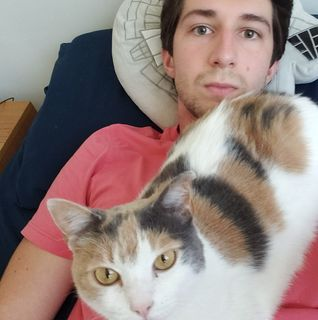

In [3]:
from PIL import Image
import requests

user_id = "12150189192" # This is retrieved via the "Account overview" page on Spotify
profile_pic_url = spotify.user(user_id)['images'][0]['url']
Image.open(requests.get(profile_pic_url, stream=True).raw)

We're definitely connected Spotify, this is my profile picture of myself and my cat, Josie. Maybe listening to Spotify at the time, no way of knowing that via the API though.

Awesome. Now we can check out the details of what I've been listening to. For streaming history, this had to be requested ahead of time from the "Download Data" section of [Privacy settings](https://www.spotify.com/us/account/privacy/). The streaming history files show each instance of a played song and how long that song was played for.

The notebook loads in the files that were requested to a `pandas` dataframe.

In [4]:
import pandas as pd
from glob import glob

history_files = glob(os.path.join("spotify_data/", "StreamingHistory*.json"))
streams_df = (pd.read_json(f) for f in history_files)
spotify_streams = pd.concat(streams_df, ignore_index=True)

spotify_streams.head()

endTime      artistName                     trackName  msPlayed
0  2021-07-09 15:56  XANAKIN SKYWOK                     Limo Boys     48649
1  2021-07-16 15:40     Erica Banks  Buss It (feat. Travis Scott)    116378
2  2021-07-19 00:00           Bcalm               Floating Castle    166000
3  2021-07-19 00:02         FloFilz                        Letsoh    142350
4  2021-07-19 00:06             WYS                     Satellite    233296

Let's get the total listen time for each song by concatenation of listen time `msPlayed` for each duplicate track. We won't be using the `endTime` field, so we can drop that column.

In [5]:
spotify_streams_cleaned = pd.DataFrame(columns=spotify_streams.columns.values).drop(columns='endTime')

for i, row in spotify_streams.iterrows():
    if i == 0:
        data = [row['artistName'], row['trackName'], row['msPlayed']]
        spotify_streams_cleaned.loc[len(spotify_streams_cleaned)] = data
    else:
        try:
            if row['artistName'] in spotify_streams_cleaned['artistName'].values and \
                    row['trackName'] in spotify_streams_cleaned['trackName'].values:
                index = spotify_streams_cleaned.index[(spotify_streams_cleaned['artistName'] == row['artistName']) & (spotify_streams_cleaned['trackName'] == row['trackName'])].values[0]
                spotify_streams_cleaned.at[index, 'msPlayed'] += row['msPlayed']
            else:
                data = [row['artistName'], row['trackName'], row['msPlayed']]
                spotify_streams_cleaned.loc[len(spotify_streams_cleaned)] = data
        except IndexError:
            pass

spotify_streams = spotify_streams_cleaned
spotify_streams.head()

artistName                     trackName  msPlayed
0  XANAKIN SKYWOK                     Limo Boys     48649
1     Erica Banks  Buss It (feat. Travis Scott)    525905
2           Bcalm               Floating Castle    332000
3         FloFilz                        Letsoh    142350
4             WYS                     Satellite    466592

The dataframe can now be sorted by my most listened to tracks in descending order. For ease of visualization and calculations, we can just take my top 100 listened to songs for our audio analysis.

In [6]:
spotify_streams = spotify_streams.sort_values(by='msPlayed', ascending=False).reset_index(drop=True).head(100)
spotify_streams.head()

artistName                             trackName  msPlayed
0     Metallica        Master of Puppets (Remastered)  39828934
1     Metallica           Seek & Destroy (Remastered)  27655021
2        Slayer                        Angel Of Death  26426311
3     Metallica  For Whom The Bell Tolls (Remastered)  19394961
4  Judas Priest                            Painkiller  16734307

Wow, I've listened to a LOT of Metallica. That's over 11 hours of Master of Puppets alone. **Before** Stranger Things re-popularized it.

We should now have unique instances of every song and its total time played in milliseconds.

Now is time to request song metadata via Spotipy API. To do so, we need the unique "Track ID" of each song.

We will also need "Artist ID" and "Popularity" for later (spoiler alert!), so we will obtain that here as well.

In [7]:
for i, row in spotify_streams.iterrows():
    try:
        search_result = spotify.search(q="artist:\"{artist}\"+track:\"{track}\"".format(artist=row['artistName'], track=row['trackName']), type="track", limit=1)
        track_id = search_result['tracks']['items'][0]['id']
        artist_id = search_result['tracks']['items'][0]['artists'][0]['id']
        popularity = search_result['tracks']['items'][0]['popularity']
        spotify_streams.loc[i, 'trackID'] = track_id
        spotify_streams.loc[i, 'artistID'] = artist_id
        spotify_streams.loc[i, 'popularity'] = popularity
    except IndexError:
        pass

spotify_streams = spotify_streams.dropna().reset_index(drop=True)
spotify_streams.head()

artistName                             trackName  msPlayed  \
0     Metallica        Master of Puppets (Remastered)  39828934   
1     Metallica           Seek & Destroy (Remastered)  27655021   
2        Slayer                        Angel Of Death  26426311   
3     Metallica  For Whom The Bell Tolls (Remastered)  19394961   
4  Judas Priest                            Painkiller  16734307   

                  trackID                artistID  popularity  
0  54bm2e3tk8cliUz3VSdCPZ  2ye2Wgw4gimLv2eAKyk1NB        80.0  
1  5DrNFzZZZVfXaEZCaceKnp  2ye2Wgw4gimLv2eAKyk1NB        64.0  
2  61dTqhd46yMkSWmC5LAh5F  1IQ2e1buppatiN1bxUVkrk        58.0  
3  51YZAJhOwIC5Gg3jMbAmhZ  2ye2Wgw4gimLv2eAKyk1NB        72.0  
4  0L7zm6afBEtrNKo6C6Gj08  2tRsMl4eGxwoNabM08Dm4I        68.0

## Volume across song

We can then use that track ID to request the audio analysis of each track.

We will specifically look at volume levels over track segments for this portion. With this we can assess just how much I enjoy a build at a beginning of a song or a fade out. For this we can use just my top 20 songs.

In [8]:
volume_data = pd.DataFrame(columns=["Artist", "Track", "Start (Sec)", "Loudness"])

for i, row in spotify_streams.head(20).iterrows():
    try:
        segments = spotify.audio_analysis(row['trackID'])['segments']
        for segment in segments:
            data = [row['artistName'], row['trackName'], segment['start'], segment['loudness_start']]
            volume_data.loc[len(volume_data)] = data
    except AttributeError:
        pass

volume_data = volume_data.dropna()
volume_data.head()

Artist                           Track  Start (Sec)  Loudness
0  Metallica  Master of Puppets (Remastered)      0.00000   -60.000
1  Metallica  Master of Puppets (Remastered)      0.26902   -58.988
2  Metallica  Master of Puppets (Remastered)      1.38159   -58.467
3  Metallica  Master of Puppets (Remastered)      1.65977   -19.282
4  Metallica  Master of Puppets (Remastered)      1.94472   -20.198

We can use `altair` to plot line chart of all my favorites songs' loudness by segment.

In [9]:
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

alt.Chart(volume_data).mark_line().encode(
    x='Start (Sec)',
    y='Loudness',
    color='Artist',
    strokeDash='Track',
)

alt.Chart(...)

## Tempo across song

Alternatively, we can examine how tempo progresses across my top songs. This shows just how energetic my top 20 favorite tracks are.

In [10]:
tempo_data = pd.DataFrame(columns=["Artist", "Track", "Start (Sec)", "Tempo (BPM)"])

for _, row in spotify_streams.head(20).iterrows():
    try:
        sections = spotify.audio_analysis(row['trackID'])['sections']
        for section in sections:
            if section['tempo'] != 0:
                data = [row['artistName'], row['trackName'], section['start'], section['tempo']]
                tempo_data.loc[len(tempo_data)] = data
    except AttributeError:
        pass

tempo_data = tempo_data.dropna()
tempo_data.head()

Artist                           Track  Start (Sec)  Tempo (BPM)
0  Metallica  Master of Puppets (Remastered)      0.00000      106.415
1  Metallica  Master of Puppets (Remastered)      8.21378      106.057
2  Metallica  Master of Puppets (Remastered)     61.60737      106.798
3  Metallica  Master of Puppets (Remastered)     78.68684      104.194
4  Metallica  Master of Puppets (Remastered)    109.17725      107.272

Let's plot the line chart of all my songs’ tempo by segment again with `altair`.

In [11]:
alt.Chart(tempo_data).mark_line().encode(
    x='Start (Sec)',
    y='Tempo (BPM)',
    color='Artist',
    strokeDash='Track',
)

alt.Chart(...)

## Popularity of Top Songs

We can visualize the distribution of song popularity in my top listens with `matplotlib`. With this we can see *just* how underground my music taste is. Maybe not at all.

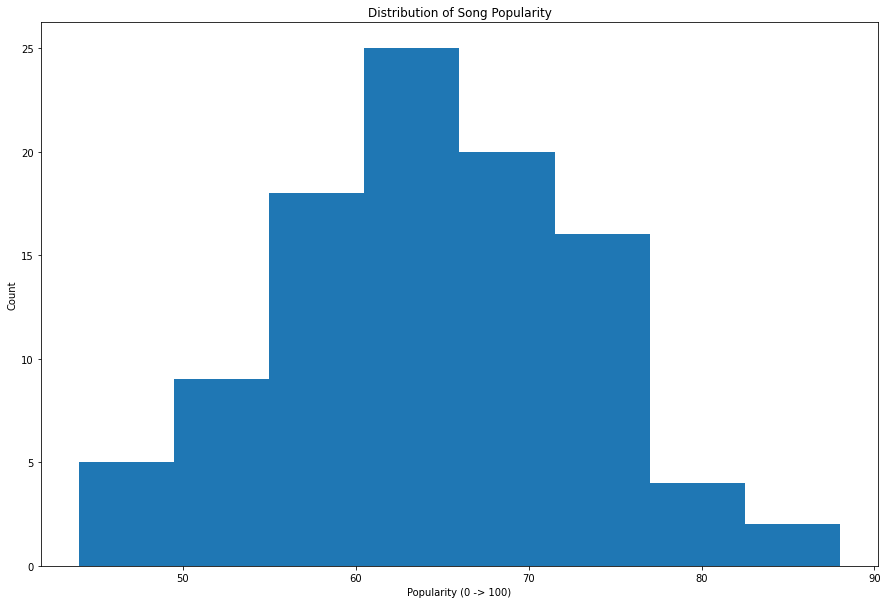

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.subplots(figsize=(15, 10))
# Creating plot
plt.hist(spotify_streams['popularity'], bins='sturges')
plt.title("Distribution of Song Popularity")
plt.xlabel("Popularity (0 -> 100)")
plt.ylabel("Count")
plt.show()

## Top Genres

Another visualization possible is to associate each track that I have listened to with a genre and that genre's total listen time. To find genre of a song, we take the artist's highest associated genre. This is certainly an imperfect assessment, but Spotify does not assign genres to specific songs.

We will need to add top artist genre to our `spotify_streams` dataframe.

In [13]:
for i, row in spotify_streams.iterrows():
    try:
        genre = spotify.artist(row['artistID'])['genres'][0]
        spotify_streams.loc[i, 'genre'] = genre
    except AttributeError:
        pass
spotify_streams.head()

artistName                             trackName  msPlayed  \
0     Metallica        Master of Puppets (Remastered)  39828934   
1     Metallica           Seek & Destroy (Remastered)  27655021   
2        Slayer                        Angel Of Death  26426311   
3     Metallica  For Whom The Bell Tolls (Remastered)  19394961   
4  Judas Priest                            Painkiller  16734307   

                  trackID                artistID  popularity  \
0  54bm2e3tk8cliUz3VSdCPZ  2ye2Wgw4gimLv2eAKyk1NB        80.0   
1  5DrNFzZZZVfXaEZCaceKnp  2ye2Wgw4gimLv2eAKyk1NB        64.0   
2  61dTqhd46yMkSWmC5LAh5F  1IQ2e1buppatiN1bxUVkrk        58.0   
3  51YZAJhOwIC5Gg3jMbAmhZ  2ye2Wgw4gimLv2eAKyk1NB        72.0   
4  0L7zm6afBEtrNKo6C6Gj08  2tRsMl4eGxwoNabM08Dm4I        68.0   

               genre  
0          hard rock  
1          hard rock  
2  alternative metal  
3          hard rock  
4         album rock

Now we can create a simple genre and time listened to dataframe to aid in our visualization by extracting our desired columns and adding time listened as we did for duplicate songs previously. After seeing that I had 20+ genres of hip hop, categorization became necessary. I tailored the categories to be my top 4, plus a single bucket for the remaining genres.

In [14]:
def assign_genre(genre_orig):
    if "hip hop" in genre_orig:
        return "Hip-Hop"
    elif "rap" in genre_orig or "crunk" in genre_orig or "trap" in genre_orig:
        return "Rap"
    elif "metal" in genre_orig:
        return "Metal"
    elif "rock" in genre_orig:
        return "Rock"
    # elif "dance" in genre_orig or "pop" in genre_orig:
    #     return "Pop"
    # elif "electronic" in genre_orig or "glitch" in genre_orig:
    #     return "Electronic"
    else:
        return "Other"

genre_data = pd.DataFrame(columns=['genre', 'msPlayed'])

for i, row in spotify_streams.iterrows():
    if i == 0:
        data = [assign_genre(row['genre']), row['msPlayed']]
        genre_data.loc[len(genre_data)] = data
    else:
        try:
            if assign_genre(row['genre']) in genre_data['genre'].values:
                index = genre_data.index[genre_data['genre'] == assign_genre(row['genre'])].values[0]
                genre_data.at[index, 'msPlayed'] += row['msPlayed']
            else:
                data = [assign_genre(row['genre']), row['msPlayed']]
                genre_data.loc[len(genre_data)] = data
        except IndexError:
            pass

genre_data.head()

genre   msPlayed
0     Rock  205384341
1    Metal  256598043
2  Hip-Hop  218632247
3      Rap   43372754
4    Other   15465973

To visualize categorical data alongside frequency, a radar chart can be used. Plotly offers a great package for visualizing radar charts.

In [15]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Scatterpolar(r=genre_data['msPlayed'].values, theta=genre_data['genre'].values, fill='toself', name='Scott Berry'),
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Genre listens comparison'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

fig.show()

This template was intended to stack multiple user streaming histories, which would work well by appending more entries to the `data` array field.

## Create LyricsGenius client

Now let's check something a little different, what words do I hear the most in my music?

To do that, we create a Genius client via "lyricsgenius". We can follow the same basic steps taken to create the Spotify client but now at [Lyrics.com](https://www.lyrics.com/login.php) which has an API as well.

In [16]:
import lyricsgenius

load_dotenv(dotenv_path='lyricsgenius.env')
client_token=os.environ.get('LYRICSGENIUS_CLIENT_ACCESS_TOKEN')

genius = lyricsgenius.Genius(client_token)

Here we request all of my top songs lyrics to add them to a word count dataframe.

Stop Words and unwanted noise is removed (words in brackets of any type) as these words and their respective counts are added to the dataframe. We only need to see the top 100 words to have a good visualization.

In [17]:
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

word_counts = pd.DataFrame(columns=["Word", "Count"])
for i, row in spotify_streams.iterrows():
    try:
        lyrics = genius.search_song(row['trackName'], row['artistName']).lyrics
        words = word_tokenize(re.sub("\((.*?)\)", "", re.sub("\[(.*?)\]", "", lyrics)))
        for word in words:
            word = word.lower()
            if word.isalpha() and word not in stop_words:
                if word in word_counts['Word'].values:
                    word_counts.loc[word_counts['Word'] == word, 'Count'] += 1
                else:
                    word_counts.loc[len(word_counts)] = [word, 1]
    except:
        pass

word_counts = word_counts.sort_values(by="Count", ascending=False).reset_index(drop=True).head(100)
word_counts.head()

Searching for "Master of Puppets (Remastered)" by Metallica...
Done.
Searching for "Seek & Destroy (Remastered)" by Metallica...
Done.
Searching for "Angel Of Death" by Slayer...
Done.
Searching for "For Whom The Bell Tolls (Remastered)" by Metallica...
Done.
Searching for "Painkiller" by Judas Priest...
Done.
Searching for "Battery (Remastered)" by Metallica...
Done.
Searching for "Holy Wars...The Punishment Due - Remastered" by Megadeth...
No results found for: 'Holy Wars...The Punishment Due - Remastered Megadeth'
Searching for "One (Remastered)" by Metallica...
Done.
Searching for "Pull Me Under" by Dream Theater...
Done.
Searching for "Unsainted" by Slipknot...
Done.
Searching for "Duality" by Slipknot...
Done.
Searching for "South Of Heaven" by Slayer...
Done.
Searching for "Kryptonite" by Killer Mike...
Done.
Searching for "Sugar" by System Of A Down...
Done.
Searching for "Raining Blood" by Slayer...
Done.
Searching for "Steppin On The Beat (with TrippythaKid)" by Yung Gravy...

Word  Count
0    one   1466
1  would   1049
2   like    808
3  swann    736
4    mme    614

Using the Wordcloud library we can create a word map from frequencies to see what words I most frequently hear from Spotify songs. It will be entertaining to see the words associated with the genres that I listen to.

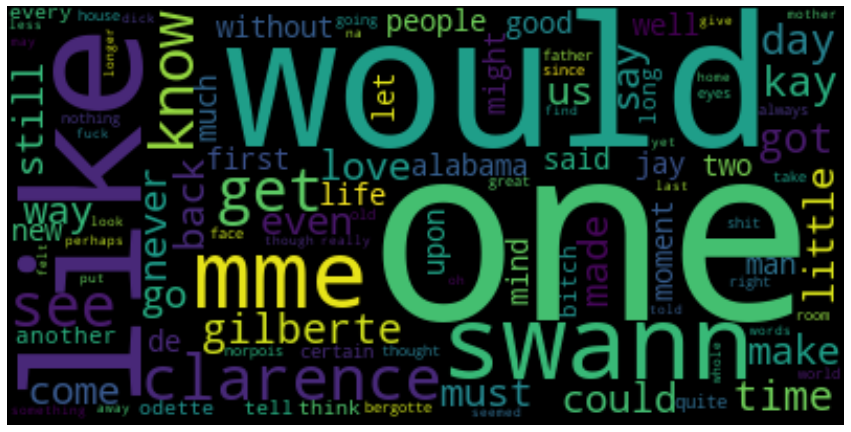

In [18]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

word_count_dict = {}
for _, row in word_counts.iterrows():
    word_count_dict[row['Word']] = row['Count']

wc = WordCloud().generate_from_frequencies(word_count_dict)

plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()